<a href="https://colab.research.google.com/github/MokshAggarwal/Hate-Speech-Detection/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
# from plot_learning_curve import plot_learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, ShuffleSplit, learning_curve
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from gensim.models import FastText, Word2Vec
from gensim.test.utils import common_texts
import multiprocessing
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, roc_curve, precision_score, recall_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
 
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

Reading the jigsaw dataset

In [ ]:
xtrain = pd.read_csv('/content/drive/MyDrive/jigsaw dataset/train.csv')
xtrain

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


# Preprocessing
#### Simplifying the jigsaw dataset into 2 classes Hate and Non-Hate

In [ ]:
xtrain['category']=''
xtrain['category']=xtrain['toxic'] | xtrain['severe_toxic'] | xtrain['obscene'] | xtrain['identity_hate'] | xtrain['threat'] | xtrain['insult']
display(xtrain)
# xtrain['category'].value_counts()
xtrain.drop(xtrain.columns[[0, 2,3,4,5,6,7]], axis = 1, inplace = True)
display(xtrain)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,category
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0


,comment_text,category
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


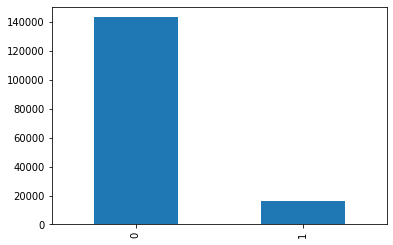

In [ ]:
xtrain['category'].value_counts().plot(kind='bar')
# sns.countplot(x='category', data=xtrain ,legend = ['Non-Hate', 'Hate'])
# plt.legend(labels = )
plt.show()
# y

In [ ]:
xtrain2=pd.read_csv('/content/drive/MyDrive/jigsaw dataset/DavidsonHateSpeechData.csv')
xtrain2.drop(xtrain2.columns[[0, 1, 2,3,4]], axis = 1, inplace = True)
xtrain2 = xtrain2[xtrain2['class'].values<2]
xtrain2['class']=1
xtrain2.rename(columns = {'class':'category','tweet':'comment_text'}, inplace = True)
display(xtrain2)

,category,comment_text
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
...,...,...
24776,1,you're all niggers
24777,1,you're such a retard i hope you get type 2 dia...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24780,1,young buck wanna eat!!.. dat nigguh like I ain...


In [ ]:
final_xtrain = pd.concat([xtrain, xtrain2])
# display(final_xtrain)
print(final_xtrain['category'].value_counts())
final_xtrain

0    143346
1     36845
Name: category, dtype: int64


,comment_text,category
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
24776,you're all niggers,1
24777,you're such a retard i hope you get type 2 dia...,1
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1
24780,young buck wanna eat!!.. dat nigguh like I ain...,1


In [ ]:
hate=final_xtrain[final_xtrain['category']==1].sample(n = 20000)
non_hate=final_xtrain[final_xtrain['category']==0].sample(n = 30000)
final_xtrain=pd.concat([hate, non_hate])
final_xtrain = final_xtrain.sample(frac = 1)
final_xtrain.reset_index(drop=True, inplace=True)
final_df = final_xtrain.applymap(lambda s:s.lower() if type(s) == str else s)


In [ ]:
final_df

,comment_text,category
0,"""\nlisten up, sj, are you going to let me show...",0
1,@lnsightful @zt_supreme @uncr4fted @yopapi_chu...,1
2,r u starting to sweat nybrad ?,0
3,boring\n\nwhy are you so boring gail.. stop ha...,1
4,red links\nplease don't delete red links. ther...,0
...,...,...
49995,"cka4004, the reason why guilherme paula provid...",0
49996,@jnunchuckfuck u can just ask him to suck his ...,1
49997,"you are wrong on all points. and, you may be g...",0
49998,talk:nigger \n please stop your disruptive edi...,1


# Pre-processing


In [ ]:
def cleanString(comment: str) -> str:
    comment = re.sub('n\'t', '', comment)
    comment = re.sub('\'m', '', comment)
    comment = re.sub('\'ve', '', comment)
    comment = re.sub(' to ', ' ', comment)
    comment = re.sub(' the ', ' ', comment)
    comment = re.sub('\'s', '', comment)
    comment = re.sub(' is ', ' ', comment)
    comment = re.sub(' are ', ' ', comment)
    comment = re.sub(' have ', ' ', comment)
    comment = re.sub(' has ', ' ', comment)
    comment = re.sub(' a ', ' ', comment)
    comment = re.sub(' the ', ' ', comment)


    comment = comment.replace('\n', ' ')
    comment = comment.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    comment = comment.replace(r'[0-9]', '')
    # remove punctuation and numbers
    comment = re.sub('[^a-zA-Z!?%]', ' ', comment)
    comment = re.sub('[^a-zA-Z%]', ' ', comment)
    # del %
    comment = re.sub('%', '', comment)
    # remove multiple spaces
    comment = re.sub(r' +', ' ', comment)
    # remove newline
    comment = re.sub(r'\n', ' ', comment)
    # remove digits
    comment = ''.join(i for i in comment if not i.isdigit())
    comment = re.sub(r' +', ' ', comment)
    comment = comment.strip()
    return comment

def split_data(df, size):
  #dropping the last column and storing it in the target
  X=df.drop('category',axis='columns') # data 
  Y=df['category'] #  that we need to predict
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = size, random_state = 17)
  return X_train, X_test, Y_train, Y_test

In [ ]:
final_df.comment_text = final_df.comment_text.map(cleanString)

In [ ]:
X_train, X_test, Y_train, Y_test = split_data(final_df, 0.2)
print(X_train.shape, X_test.shape)
display(X_train.head())
display(Y_train.head())

(40000, 1) (10000, 1)


,comment_text
2380,rt louiev lmaoooo rt tan aaa white people lmao...
3385,tia chepa uhh noo bitch she your tia irma aghh...
41779,i ll concede shoutaboutastic though only becau...
39302,that dude rent ai no punk bitch either
20619,shut fuck up i sent my sister picture of mini ...


2380     1
3385     1
41779    0
39302    1
20619    1
Name: category, dtype: int64

# Char n-gram feature extraction

In [ ]:
vectorizer = CountVectorizer(analyzer='char_wb', ngram_range = (5, 8),strip_accents = 'ascii',min_df = 0.1, max_df = 0.9)
vectorizer = vectorizer.fit(X_train.comment_text)
countMatrix1 = vectorizer.transform(X_train.comment_text)
countMatrix2 = vectorizer.transform(X_test.comment_text)

In [ ]:
transformer = TfidfTransformer().fit(countMatrix1)
Char_train_feature = transformer.transform(countMatrix1)
Char_test_feature = transformer.transform(countMatrix2)

In [ ]:
# vectorizer.get_feature_names_out().tolist()
print(Char_train_feature.shape, Char_test_feature.shape)

(40000, 151) (10000, 151)


In [ ]:
scaler = StandardScaler()
scaler.fit(Char_train_feature.todense())
Char_train_feature_ = scaler.transform(Char_train_feature.todense())
Char_test_feature_ = scaler.transform(Char_test_feature.todense())

# Word n-gram feature extraction

In [ ]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 4),strip_accents='ascii',min_df=0.1,max_df=0.9)
vectorizer2 = vectorizer2.fit(X_train.comment_text)
countMatrix1 = vectorizer2.transform(X_train.comment_text)
countMatrix2 = vectorizer2.transform(X_test.comment_text)

In [ ]:
transformer = TfidfTransformer().fit(countMatrix1)
Word_train_feature = transformer.transform(countMatrix1)
Word_test_feature=transformer.transform(countMatrix2)

In [ ]:
print(Word_train_feature.shape, Word_test_feature.shape)

(40000, 43) (10000, 43)


In [ ]:
scaler = StandardScaler()
scaler.fit(Word_train_feature.todense())
Word_train_feature_ = scaler.transform(Word_train_feature.todense())
Word_test_feature_ = scaler.transform(Word_test_feature.todense())

In [ ]:
# print(tfidfMatrix.toarray())

# FastText features 

In [ ]:
def get_w2vdf(df):
    w2v_df = pd.DataFrame(df["comment_text"]).values.tolist()
    for i in range(len(w2v_df)):
        w2v_df[i] = w2v_df[i][0].split(" ")
    return w2v_df
  
def get_feature_vector(df, model):
  feature_vectors = []
  for i in tqdm(df.index):
    sentence = df.loc[i,'comment_text'].split(' ')
    matrix = model.wv[sentence]
    vector = np.mean(matrix, axis = 0)
    feature_vectors.append(vector.tolist())
    # print(vector)

  return feature_vectors


In [ ]:
tokenized_sentences = get_w2vdf(X_train)
model = FastText(tokenized_sentences, window = 3, min_count = 1)

In [ ]:
Fast_train_feature = get_feature_vector(X_train, model)
Fast_test_feature = get_feature_vector(X_test, model)
scaler = StandardScaler()
scaler.fit(Fast_train_feature)
Fast_train_feature_ = scaler.transform(Fast_train_feature)
Fast_test_feature_ = scaler.transform(Fast_test_feature)

100%|██████████| 10000/10000 [00:03<00:00, 3078.13it/s]


In [ ]:
len(Fast_train_feature[0])

100

In [ ]:
pd.DataFrame(Fast_train_feature, index = X_train.index)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2380,-0.972624,-0.660919,-0.399997,0.145429,-0.037022,0.435462,-0.082958,-0.610383,0.018123,0.549886,...,-0.798863,-0.491417,0.466345,0.445831,-0.109940,1.036655,0.106833,-0.350291,0.202777,0.135126
3385,-0.281149,-0.520307,0.021235,0.439854,0.410215,0.059106,-0.425120,-1.269401,-0.176935,0.797179,...,0.073956,-0.447767,0.209709,0.647934,-0.888754,0.540257,0.540427,-0.523463,-0.348005,0.343061
41779,-0.411383,0.229994,0.229135,-0.026925,-0.004050,0.320041,-0.762700,-1.534016,-0.413490,0.689485,...,0.645070,-0.907517,-0.767056,0.591987,-1.113836,-0.144067,0.667405,-0.527085,-0.372092,0.052451
39302,-0.610206,0.302912,0.010012,-0.107673,-0.225317,0.549074,-0.681226,-2.159993,-0.311925,0.225047,...,0.440626,-0.799323,0.135546,0.895744,-0.787419,-0.074537,0.985953,-0.587105,-0.935604,1.156112
20619,-0.153252,-0.251968,0.334232,-0.139318,-0.101759,0.665320,-0.401578,-1.369238,-0.203362,1.295051,...,0.384343,0.049178,-0.561421,0.895882,-0.354620,-0.059866,0.967499,-0.652266,0.044371,0.574900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42297,-0.354789,-0.538416,-0.052663,-0.075601,0.155963,0.110890,-0.697398,-1.560086,-0.734520,1.765215,...,0.454528,-0.388740,0.249167,0.303211,-1.350091,0.919738,0.947774,-1.069815,-0.892784,0.916246
33174,0.114922,0.003797,0.031704,0.060139,-0.025024,0.346103,-1.158565,-1.025398,-0.384660,0.539411,...,0.888573,-0.476397,-0.603158,0.055567,-1.169615,0.031449,0.780572,0.002297,-0.786662,0.019871
46470,-0.429025,0.071357,0.325562,-0.421781,0.284140,0.250376,-0.743687,-1.498035,-0.500561,0.730590,...,0.613297,-0.820998,-0.483735,0.569456,-0.852418,-0.350385,0.469605,-0.766139,0.065370,-0.119672
34959,-0.342939,-0.337637,0.824257,-0.005187,0.171923,0.302430,-0.336982,-1.696921,-0.379339,0.824212,...,0.207014,-0.685887,-0.606939,1.494793,-0.368822,-0.092753,0.882539,-0.440633,0.193911,0.626073


In [ ]:
X_train_features_final=np.concatenate([Char_train_feature.todense(), Word_train_feature.todense(), Fast_train_feature],axis=1)
X_train_features_final.shape
X_train_features_final=pd.DataFrame(X_train_features_final)
X_train_features_final
scaler = StandardScaler()
scaler.fit(X_train_features_final)
X_train_features_final = scaler.transform(X_train_features_final)




In [ ]:
X_test_features_final=np.concatenate([Char_test_feature.todense(), Word_test_feature.todense(), Fast_test_feature],axis=1)
X_test_features_final.shape
X_test_features_final=pd.DataFrame(X_test_features_final)
X_test_features_final
X_test_features_final = scaler.transform(X_test_features_final)

Average Skewness for Char N Gram feature Set 3.6127191004968293
Average Skewness for Word N Gram feature Set 3.4173969980858363
Average Skewness for Fastext feature Set 0.03350298435873349
Average Skewness for Combined feature Set 2.3667311344509714


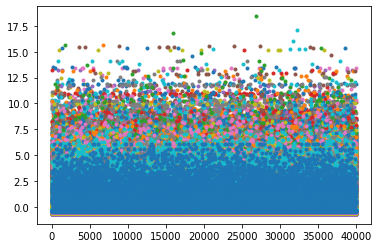

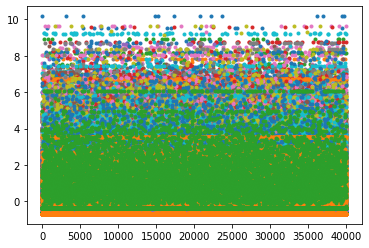

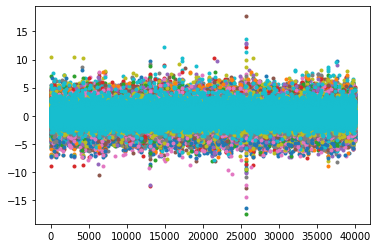

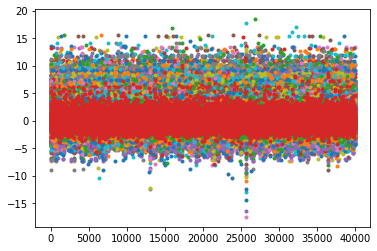

In [ ]:
from scipy.stats import skew
import numpy as np 
import pylab as p 
  
# x1 = np.linspace( -5, 12, 1000 )
# y1 = 1./(np.sqrt(2.*np.pi)) * np.exp( -.5*(x1)**2  )
# p.subplot(1, 3, 3)
  

skew_char = np.array(skew(Char_train_feature_))
skew_word = np.array(skew(Word_train_feature_))
skew_fast = np.array(skew(Fast_train_feature_))
skew_com = np.array(skew(X_train_features_final))

# print( 'Skewness for data : ', skew(Char_train_feature_))
print('Average Skewness for Char N Gram feature Set', np.average(skew_char))
print('Average Skewness for Word N Gram feature Set', np.average(skew_word))
print('Average Skewness for Fastext feature Set', np.average(skew_fast))
print('Average Skewness for Combined feature Set', np.average(skew_com))

p.plot(Char_train_feature_, '.')
p.show()
p.plot(Word_train_feature_, '.')
p.show()
p.plot(Fast_train_feature_, '.')
p.show()
p.plot(X_train_features_final, '.')

In [ ]:
def get_error_indexes(grid_obj, Y_test, test_feature):
  y_pred = grid_obj.predict(test_feature)
  y_test = np.array(Y_test)

  indexes1 = []
  indexes2 = []

  for i in range(len(y_pred)):
    #Identify all the hate comments that were classified as non hate
    if(y_test[i] == 1 and y_pred[i] == 0 ):
      indexes1.append(i)
    #Identify all the non - hate comments that were classified as hate
    if(y_test[i] == 0 and y_pred[i] == 1 ):
      indexes2.append(i)
  return (indexes1, indexes2)

# Logistic Regression

In [ ]:
def LR_grid(X, Y, parameters):
  cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
  grid_search = GridSearchCV(estimator = LogisticRegression(), param_grid = parameters, n_jobs = -1, cv = 5, scoring = "accuracy")
  grid_result = grid_search.fit(X, Y)
  return grid_result


def plot_prec_recall(X, Y, model):
  Y_scores = model.predict(X)
  precision, recall, thresholds = precision_recall_curve(Y, Y_scores)
  plt.plot(precision, recall)
  plt.show()


def plot_roc_inbuilt(clf, X, Y, name, label_):
  actual_labels = Y.values
  fpr1, tpr1, thresh1 = roc_curve(actual_labels, clf.predict_proba(X)[:,1])
  auc_score1 = roc_auc_score(actual_labels, clf.predict_proba(X)[:,1])
  print("Auc Score 1")
  print(auc_score1)
  plt.plot(fpr1, tpr1, label = label_)
  plt.plot([0, 1], [0, 1], 'k')
  # title
  plt.title('ROC curve for ' + name)
  # x label
  plt.xlabel('False Positive Rate')
  # y label
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show();
  print("Area under curve =", auc_score1)


def get_scores(estimator, X, Y):
  pred = estimator.predict(X)
  f1 = f1_score(Y, pred)
  pre = precision_score(Y, pred)
  rec = recall_score(Y, pred)
  return f1, pre, rec


parameters = {'penalty' : ['l1','l2'], 'C' : [10, 1.0, 0.1], 'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}


In [ ]:
pca = PCA(n_components = 50)
pca.fit(Char_train_feature.todense())
Char_train_feature_pca = pca.transform(Char_train_feature.todense())
Char_test_feature_pca = pca.transform(Char_test_feature.todense())
grid_result_char = LR_grid(Char_train_feature_pca, Y_train, parameters)

In [ ]:
# Y_pred = grid_result_char.predict(Char_test_feature_pca)
print(get_scores(grid_result_char, Char_test_feature_pca, Y_test))

(0.7536154258168185, 0.8049199084668193, 0.7084592145015106)


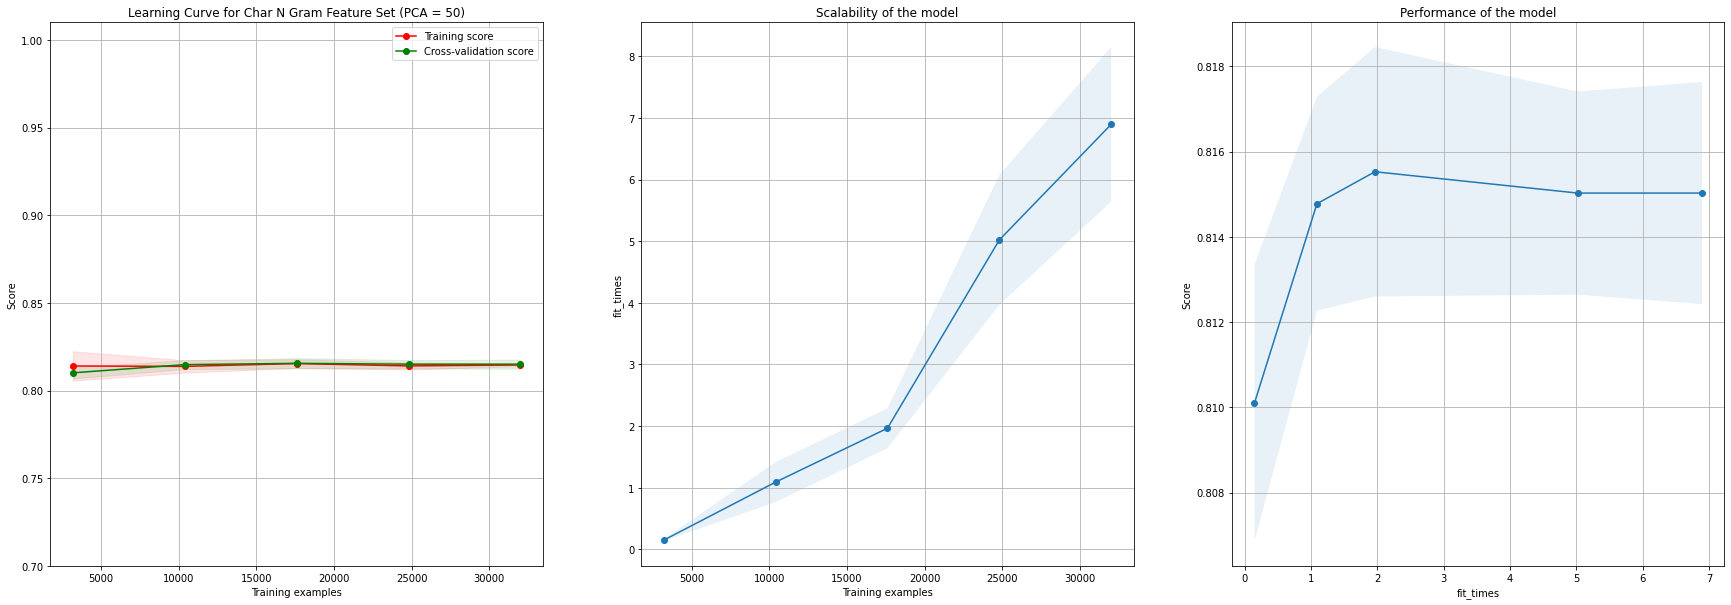

In [ ]:
title = "Learning Curve for Char N Gram Feature Set (PCA = 50)"
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
estimator = LogisticRegression(**grid_result_char.best_params_)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(
    estimator, title, Char_train_feature_pca, Y_train, axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
plt.show()

Auc Score 1
0.8903697815698609


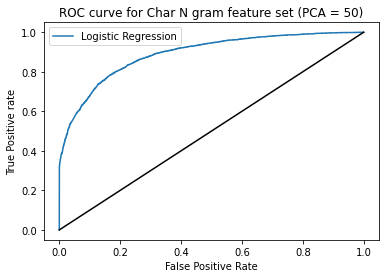

Area under curve = 0.8903697815698609


In [ ]:
plot_roc_inbuilt(grid_result_char, Char_test_feature_pca, Y_test, "Char N gram feature set (PCA = 50)", "Logistic Regression")

In [ ]:
print("Best: %f using %s" % (grid_result_char.best_score_, grid_result_char.best_params_))
print("Test results : %f" % (grid_result_char.score(Char_test_feature_pca, Y_test)))

Best: 0.813650 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Test results : 0.816000


In [ ]:
grid_result_word = LR_grid(Word_train_feature_, Y_train, parameters)

In [ ]:
print(get_scores(grid_result_word, Word_test_feature, Y_test))

(0.0, 0.0, 0.0)


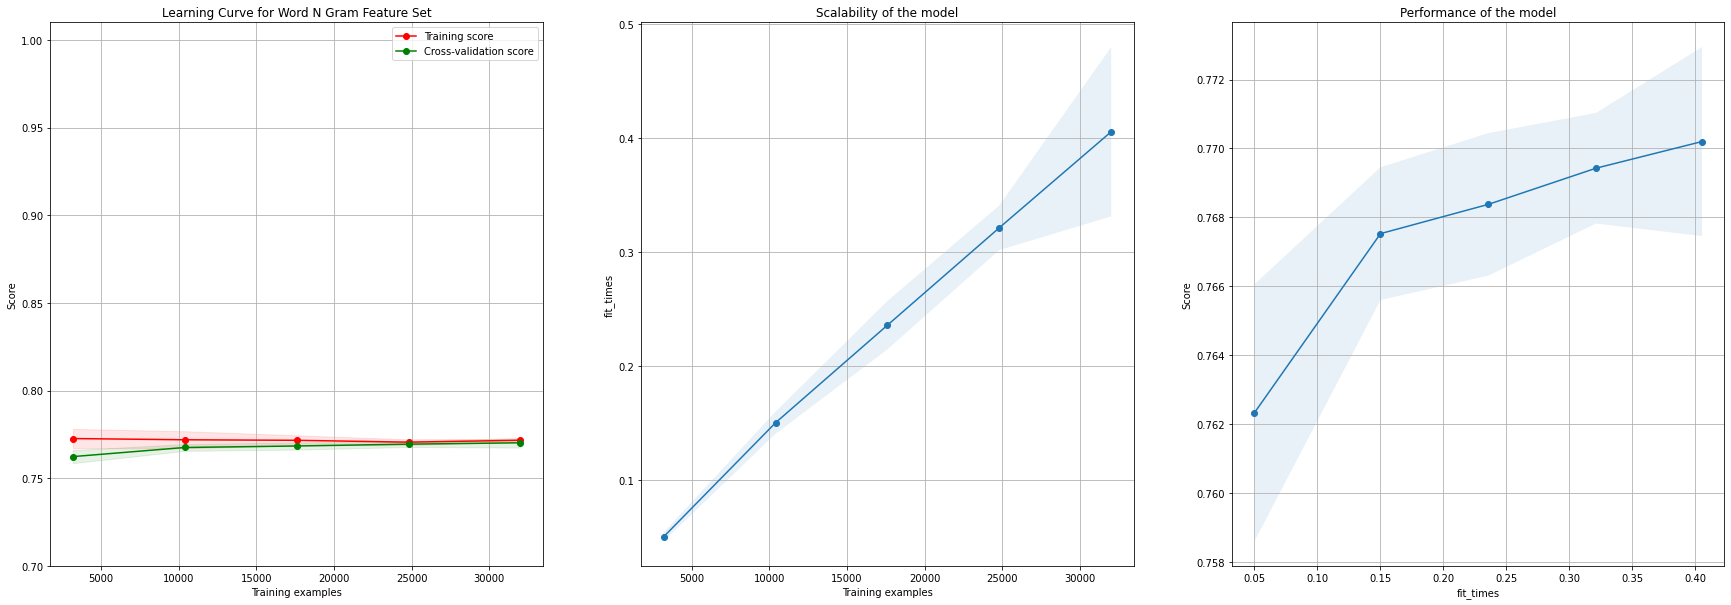

In [ ]:
title = "Learning Curve for Word N Gram Feature Set"
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
estimator = LogisticRegression(**grid_result_word.best_params_)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(
    estimator, title, Word_train_feature_, Y_train, axes, ylim = (0.7, 1.01), cv = cv, n_jobs = 4
)
plt.show()

Auc Score 1
0.8331155263353094


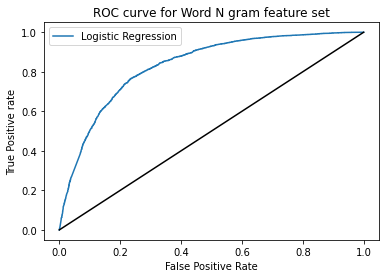

Area under curve = 0.8331155263353094


In [ ]:
plot_roc_inbuilt(grid_result_word, Word_test_feature, Y_test, "Word N gram feature set", "Logistic Regression")

In [ ]:
print("Best: %f using %s" % (grid_result_word.best_score_, grid_result_word.best_params_))
print("Test results : %f" % (grid_result_word.score(Word_test_feature_, Y_test)))

# Best: 0.776440 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
# Test results : 0.776311

Best: 0.769850 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Test results : 0.767300


In [ ]:
grid_result_fast = LR_grid(Fast_train_feature_, Y_train, parameters)

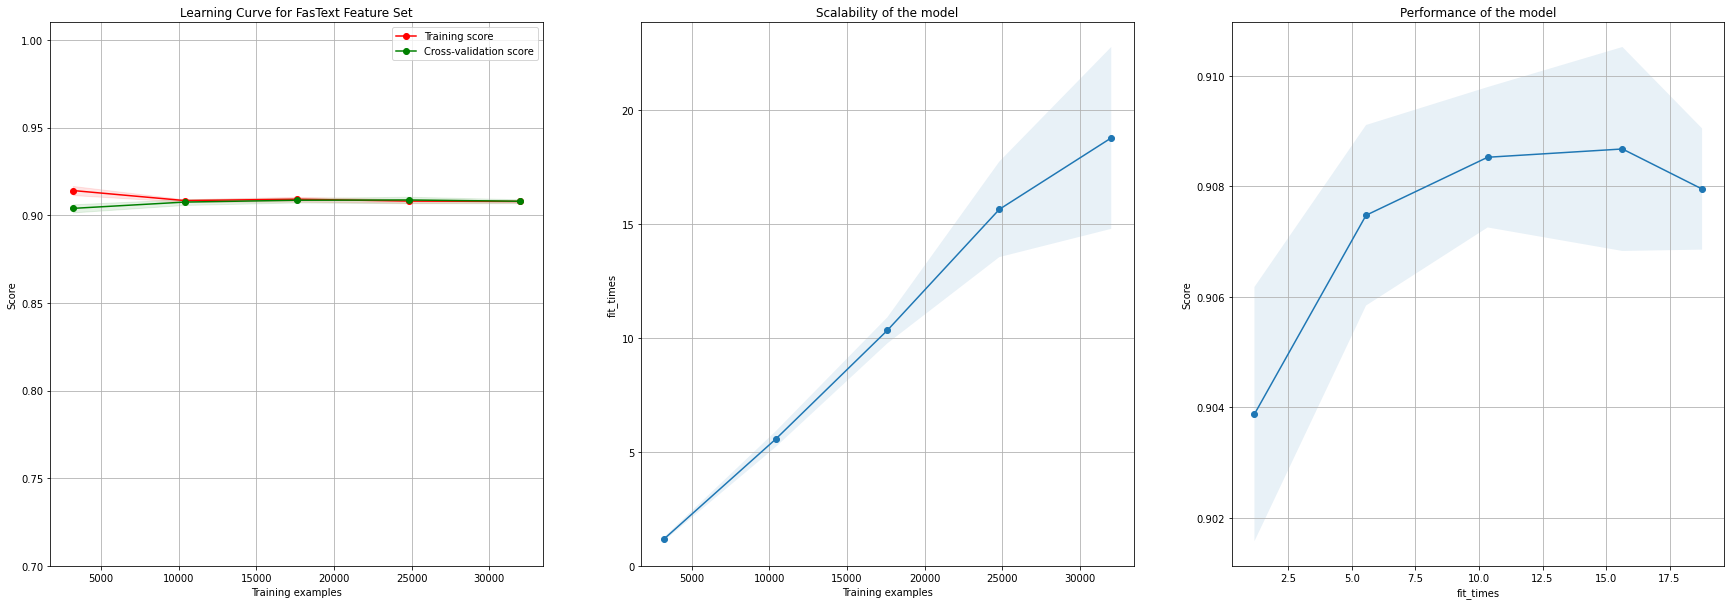

In [ ]:
title = "Learning Curve for FasText Feature Set"
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
estimator = LogisticRegression(**grid_result_fast.best_params_)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(
    estimator, title, Fast_train_feature_, Y_train, axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
plt.show()

Auc Score 1
0.9166177592851353


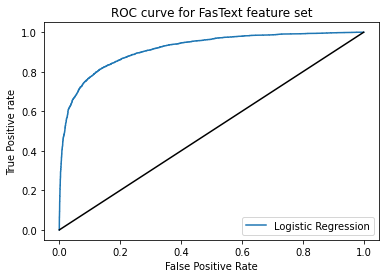

Area under curve = 0.9166177592851353


In [ ]:
plot_roc_inbuilt(grid_result_fast, Fast_test_feature, Y_test, "FasText feature set", "Logistic Regression")

In [ ]:
print("Best: %f using %s" % (grid_result_fast.best_score_, grid_result_fast.best_params_))
print("Test results : %f" % (grid_result_fast.score(Fast_test_feature_, Y_test)))

Best: 0.906875 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Test results : 0.903900


In [ ]:
pca = PCA(n_components = 75)
pca.fit(X_train_features_final)
print("Variance Retained in 75 principal features", sum(pca.explained_variance_ratio_ * 100))
pca_train_features_final = pca.transform(X_train_features_final)
pca_test_features_final = pca.transform(X_test_features_final)
grid_result_com = LR_grid(pca_train_features_final, Y_train, parameters)

Variance Retained in 75 principal features 94.9107663381496


In [ ]:
indexes1, indexes2 = get_error_indexes(grid_result_com, Y_test, pca_test_features_final)

In [ ]:
#hate comments that were classified as non hate
# false negative
display(X_test.iloc[indexes1])
false_neg = pca_test_features_final[indexes1]
predictions = grid_result_com.predict(false_neg)
Counter(Y_test.iloc[indexes1]), Counter(predictions)
# X_test.iloc[indexes1]


,comment_text
42601,i just helping reader of wikipedia not see med...
10352,your merge was worthless you basically removed...
12884,hey fuck you that information was true and i d...
44979,personally attacking you racism it makes sence...
1947,do be an ass it was clear edit conflict and wh...
...,...
49831,truly hell hath ice cubed defending jdogg it w...
47405,i agree that keep faggots was needlessly insul...
7442,there zero reliable sources and i do mean yout...
35778,your work will be deleted or bastardized wheth...


(Counter({1: 700}), Counter({0: 700}))

In [ ]:
temp_df = X_test.iloc[indexes1]
unique_word = []
all_sent = np.array(temp_df.loc[:, 'comment_text'])
for i in tqdm(all_sent):
  j = i.split()
  # print(j)
  # unique_word = unique_word.union(set(j))
  unique_word += j
  # break
# Identifying the racial bias in all the false negative
unique_words = dict(Counter(unique_word))
print("he", unique_words['he'])
print("she", unique_words['she'])
print("black", unique_words['black'])
# print("terrorists", unique_words['terrorists'])
# print("islam", unique_words['islam'])
print("muslims", unique_words['muslims'])
print("religion", unique_words['religion'])

100%|██████████| 700/700 [00:00<00:00, 101343.16it/s]

he 166
she 41
black 11
muslims 5
religion 4


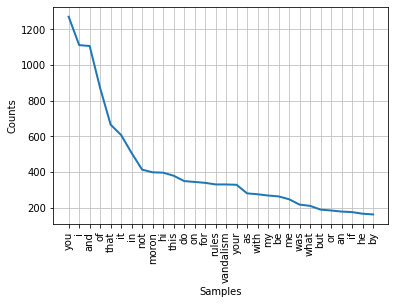

In [ ]:
fdist = FreqDist(unique_word)
fdist.plot(30,cumulative=False)
plt.show()

In [ ]:
# non - hate comments that were classified as hate
# false positive
# display(X_test.iloc[indexes2])
false_pos = pca_test_features_final[indexes2]
predictions = grid_result_com.predict(false_pos)
Counter(Y_test.iloc[indexes2]), Counter(predictions)
X_test.iloc[indexes2]

,comment_text
5724,did you know that out of million people all of...
1979,please stop if you continue vandalize wikipedi...
29185,administrator abuse it my intention report you...
15221,how can one defame someone who thinks fort hoo...
12712,no you re wrong they do hate him they love him...
...,...
39517,done thank you chillum
29594,they not serbian people of bosnia descent thei...
25826,speak llama
43784,man you sound like you re hurting guadalajara ...


In [ ]:
temp_df = X_test.iloc[indexes2]
unique_word = []
all_sent = np.array(temp_df.loc[:, 'comment_text'])
for i in tqdm(all_sent):
  j = i.split()
  # print(j)
  # unique_word = unique_word.union(set(j))
  unique_word += j
# Identifying the racial bias in all the false positives
unique_words = dict(Counter(unique_word))
print("he", unique_words['he'])
print("she", unique_words['she'])
print("black", unique_words['black'])
# print("terrorists", unique_words['terrorists'])
# print("islam", unique_words['islam'])
# print("muslims", unique_words['muslims'])

100%|██████████| 329/329 [00:00<00:00, 83880.98it/s]

he 39
she 30
black 11


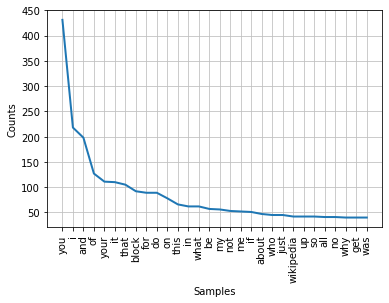

In [ ]:
fdist = FreqDist(unique_word)
fdist.plot(30,cumulative=False)
plt.show()

In [ ]:
print(get_scores(grid_result_com, pca_test_features_final, Y_test))

(0.8641225406047801, 0.9086364898639266, 0.823766364551863)


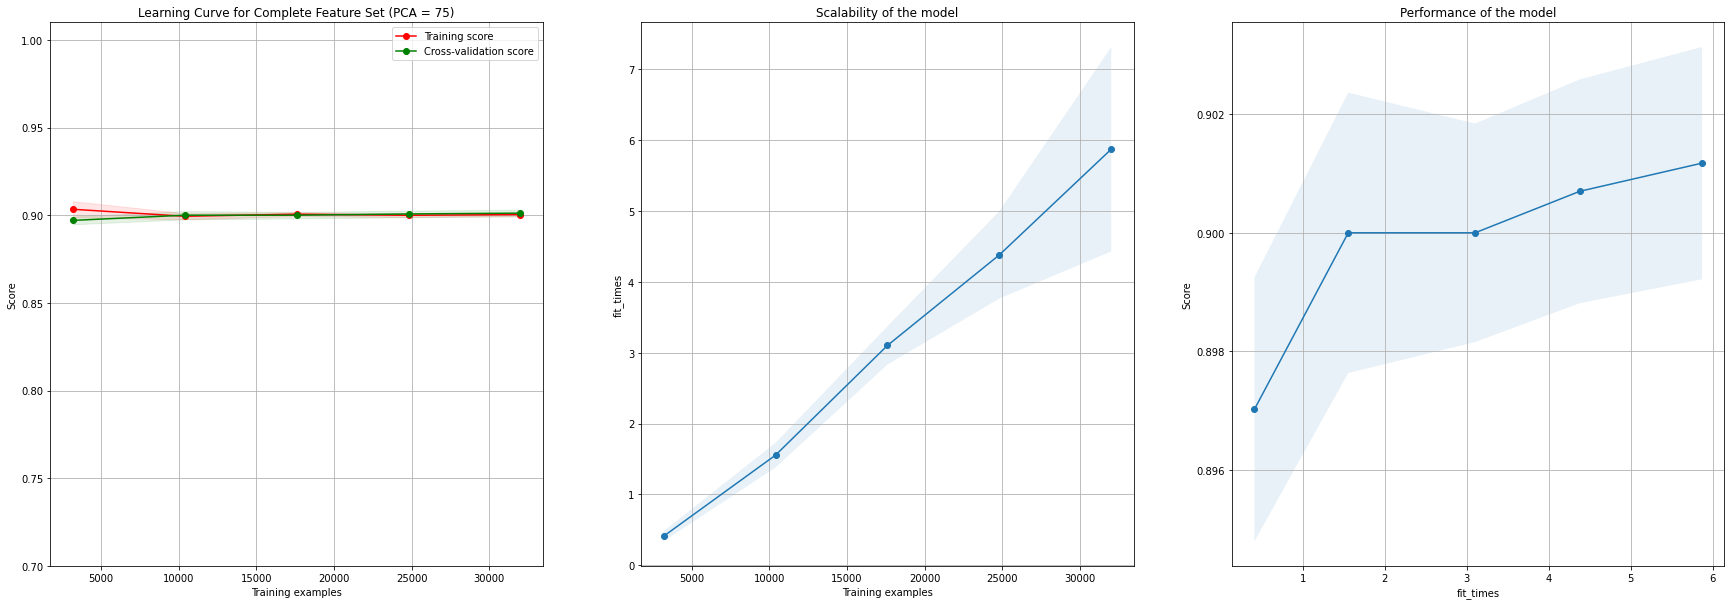

In [ ]:
title = "Learning Curve for Complete Feature Set (PCA = 75)"
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
estimator = LogisticRegression(**grid_result_com.best_params_)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(
    estimator, title, pca_train_features_final, Y_train, axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
plt.show()

Auc Score 1
0.957556787693015


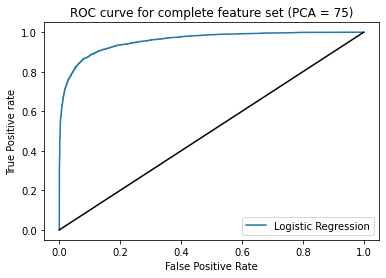

Area under curve = 0.957556787693015


In [ ]:
plot_roc_inbuilt(grid_result_com, pca_test_features_final, Y_test, "complete feature set (PCA = 75)", "Logistic Regression")

In [ ]:
print("Best: %f using %s" % (grid_result_com.best_score_, grid_result_com.best_params_))
print("Test results : %f" % (grid_result_com.score(pca_test_features_final, Y_test)))

Best: 0.899875 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Test results : 0.897100


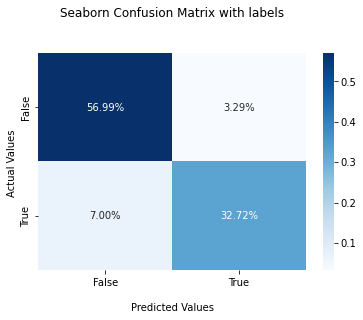

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_pred = grid_result_com.predict(pca_test_features_final)
cf_matrix = confusion_matrix(Y_test, y_pred)
# group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
# group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
# group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
# labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
# labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

# Ada Boost

In [ ]:
abc = AdaBoostClassifier(base_estimator=LogisticRegression())

parameters = {'base_estimator__penalty' : ['l1'],
              'base_estimator__C' : [1.0, 0.1],
              'base_estimator__solver'  : ['newton-cg', 'liblinear'],
              'n_estimators':[10,50],
              'learning_rate':[0.01,0.1]}
clf = GridSearchCV(abc, parameters,verbose=3,scoring='f1',n_jobs=-1)
clf.fit(pca_train_features_final, Y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=AdaBoostClassifier(base_estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'base_estimator__C': [1.0, 0.1],
                         'base_estimator__penalty': ['l1'],
                         'base_estimator__solver': ['newton-cg', 'liblinear'],
                         'learning_rate': [0.01, 0.1],
                         'n_estimators': [10, 50]},
             scoring='f1', verbose=3)

In [ ]:
print(get_scores(clf, pca_test_features_final, Y_test))

(0.7233853006681514, 0.6485623003194888, 0.8177240684793555)


In [ ]:
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
print("Test results : %f" % (clf.score(pca_test_features_final, Y_test)))

Best: 0.736060 using {'base_estimator__C': 1.0, 'base_estimator__penalty': 'l1', 'base_estimator__solver': 'liblinear', 'learning_rate': 0.01, 'n_estimators': 10}
Test results : 0.723385


In [ ]:
roc_auc_score(Y_test, clf.predict_proba(pca_test_features_final)[:,1])

0.8330882952398708

Auc Score 1
0.8330882952398708


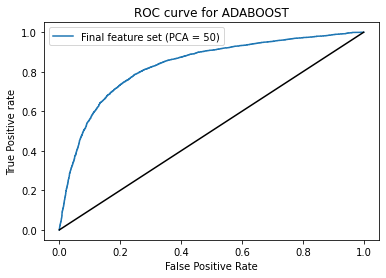

Area under curve = 0.8330882952398708


In [ ]:
plot_roc_inbuilt(clf, pca_test_features_final, Y_test, "ADABOOST" ,"Final feature set (PCA = 50)")

In [ ]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

parameters = {'base_estimator__criterion' : [ 'entropy'],
              'base_estimator__max_depth' : [15],
              'base_estimator__min_samples_split'  : [15],
              'base_estimator__min_samples_leaf'  : [15],
              'n_estimators':[10],
              'learning_rate':[0.01,0.1]}
#  "max_depth" : range(1, 5), "min_samples_split" : range(1, 5), "min_samples_leaf" : range(1, 5)
# clf = GridSearchCV(abc, parameters,verbose=3,scoring='accuracy',n_jobs=-1)
abc.fit(pca_train_features_final, Y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [ ]:
print(get_scores(clf, pca_test_features_final, Y_test))
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
print("Test results : %f" % (clf.score(pca_test_features_final, Y_test)))

(0.7233853006681514, 0.6485623003194888, 0.8177240684793555)
Best: 0.736060 using {'base_estimator__C': 1.0, 'base_estimator__penalty': 'l1', 'base_estimator__solver': 'liblinear', 'learning_rate': 0.01, 'n_estimators': 10}
Test results : 0.723385


# GradientBoostingClassifier

In [ ]:
abc = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=0, verbose = 1)

abc.fit(X_train_features_final, Y_train)

      Iter       Train Loss   Remaining Time 
         1           0.9756            3.27m
         2           0.8233            3.25m
         3           0.7749            3.22m
         4           0.7403            3.21m
         5           0.7094            3.18m
         6           0.6783            3.16m
         7           0.6641            3.15m
         8           0.6458            3.13m
         9           0.6337            3.12m
        10           0.6219            3.10m
        20           0.5614            2.92m
        30           0.5304            2.75m
        40           0.5143            2.58m
        50           0.4996            2.42m
        60           0.4893            2.25m
        70           0.4792            2.09m
        80           0.4694            1.93m
        90           0.4644            1.77m
       100           0.4579            1.61m
       200           0.4245            0.00s


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=200,
                           random_state=0, verbose=1)

In [ ]:
print(get_scores(abc, X_test_features_final, Y_test))
# print("Best: %f using %s" % (abc.best_score_, abc.best_params_))
print("Test results : %f" % (abc.score(X_test_features_final, Y_test)))

(0.8635364118484025, 0.8880021282255919, 0.8403826787512588)
Test results : 0.894500


Auc Score 1
0.9573424889956303


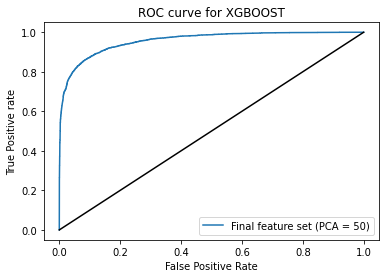

Area under curve = 0.9573424889956303


In [ ]:
plot_roc_inbuilt(abc, X_test_features_final, Y_test, "XGBOOST" ,"Final feature set (PCA = 50)")

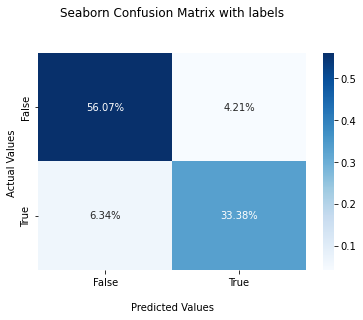

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_pred = abc.predict(X_test_features_final)
cf_matrix = confusion_matrix(Y_test, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

# Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(Char_train_feature_, Y_train)
gnb.score(Char_test_feature_, Y_test)
# y_pred=gnb.predict(Char_test_feature_)
# accuracy(Y_test,y_pred,average='macro')

0.7441

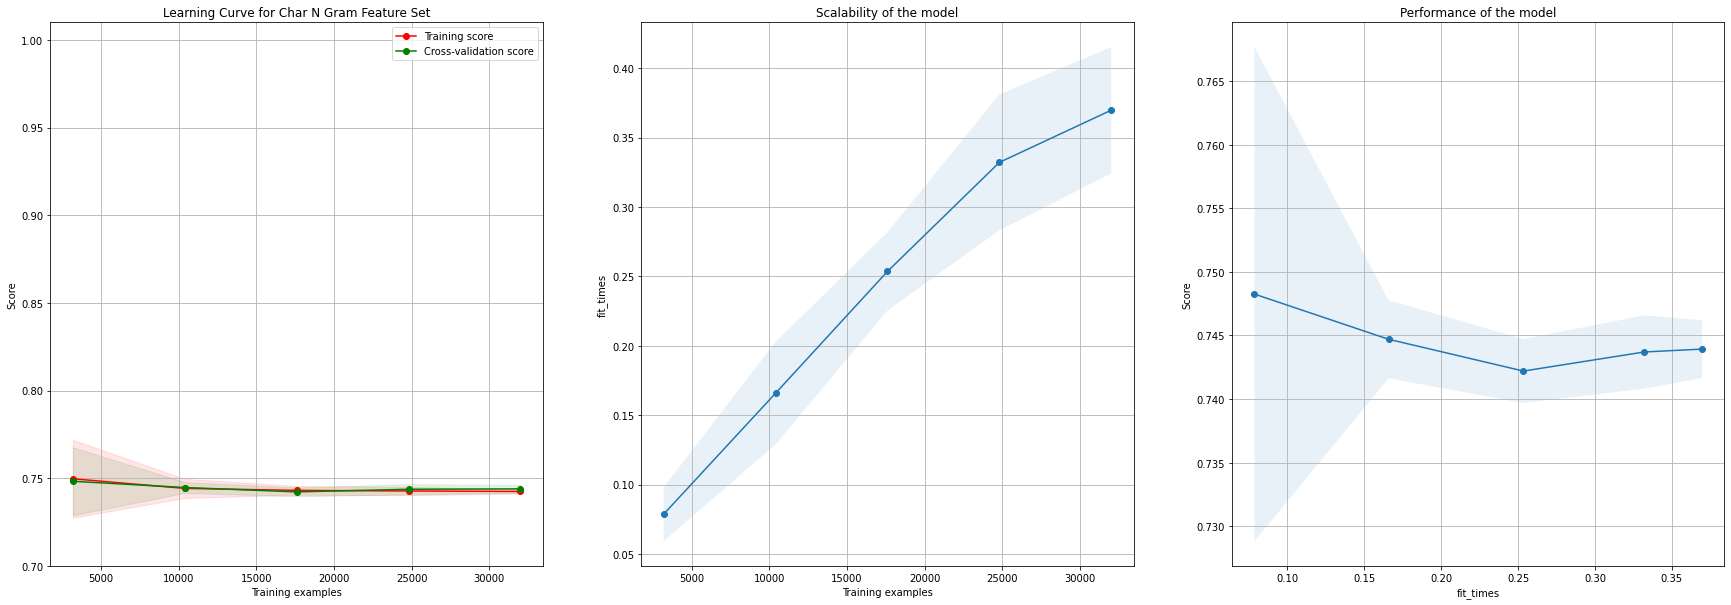

In [ ]:
title = "Learning Curve for Char N Gram Feature Set"
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
estimator = gnb
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(
    estimator, title, Char_train_feature_, Y_train, axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
plt.show()

Auc Score 1
0.8258907241199345


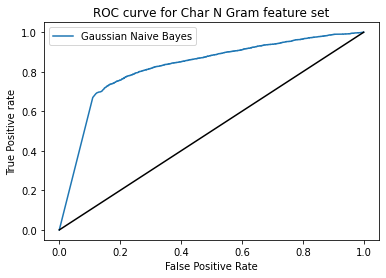

Area under curve = 0.8258907241199345


In [ ]:
plot_roc_inbuilt(gnb, Char_test_feature_, Y_test, "Char N Gram feature set", "Gaussian Naive Bayes")

In [ ]:
gnb = GaussianNB()
gnb.fit(Word_train_feature_, Y_train)
gnb.score(Word_test_feature_, Y_test)
# y_pred=gnb.predict(Word_test_feature_)
# f1_score(Y_test,y_pred,average='macro')

0.7357

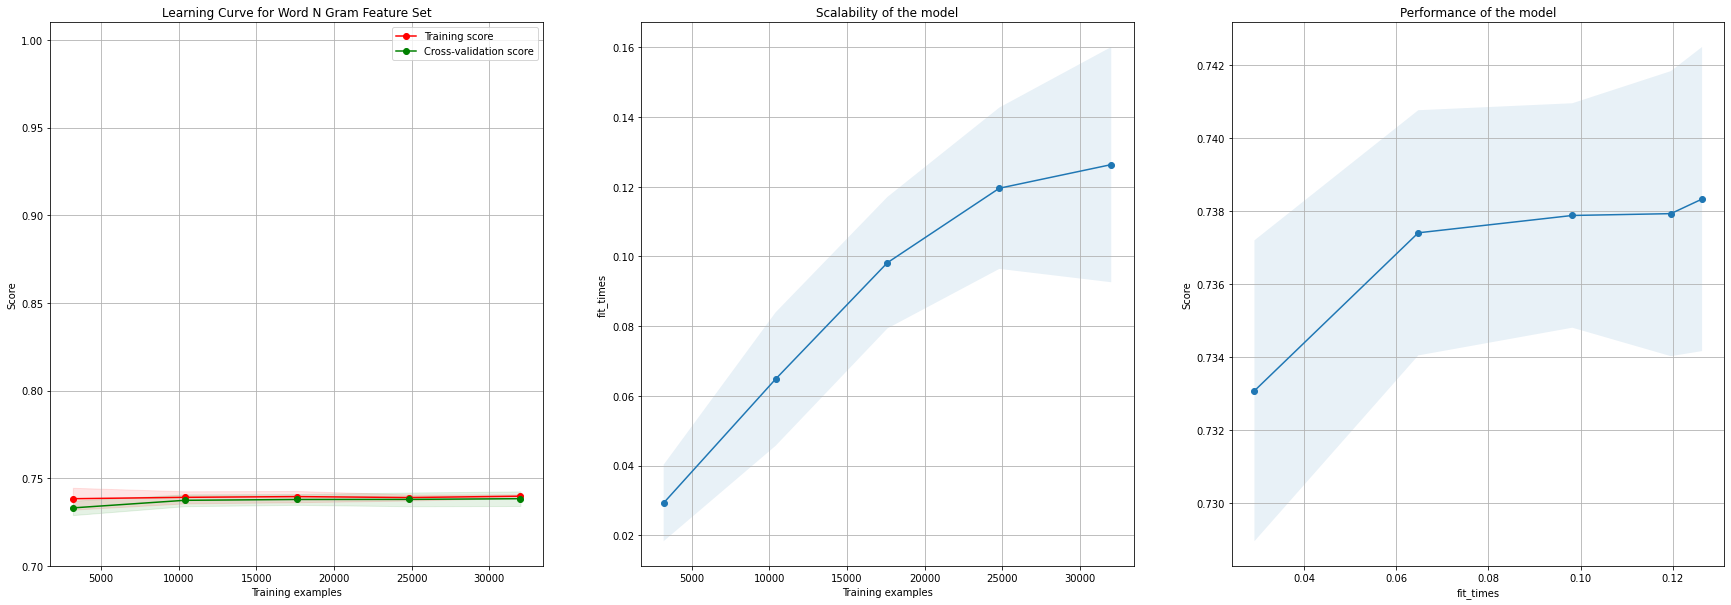

In [ ]:
title = "Learning Curve for Word N Gram Feature Set"
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
estimator = gnb
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(
    estimator, title, Word_train_feature_, Y_train, axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
plt.show()

Auc Score 1
0.7978036033254681


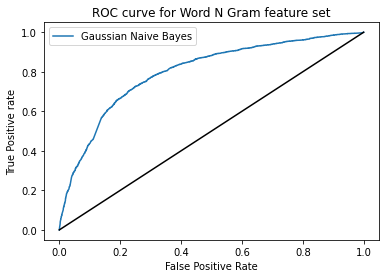

Area under curve = 0.7978036033254681


In [ ]:
plot_roc_inbuilt(gnb, Word_test_feature_, Y_test, "Word N Gram feature set", "Gaussian Naive Bayes")

In [ ]:
gnb = GaussianNB()
gnb.fit(Fast_train_feature_, Y_train)
gnb.score(Fast_test_feature_, Y_test)

# y_pred=gnb.predict(Fast_test_feature_)
# f1_score(Y_test,y_pred,average='macro')

0.8237

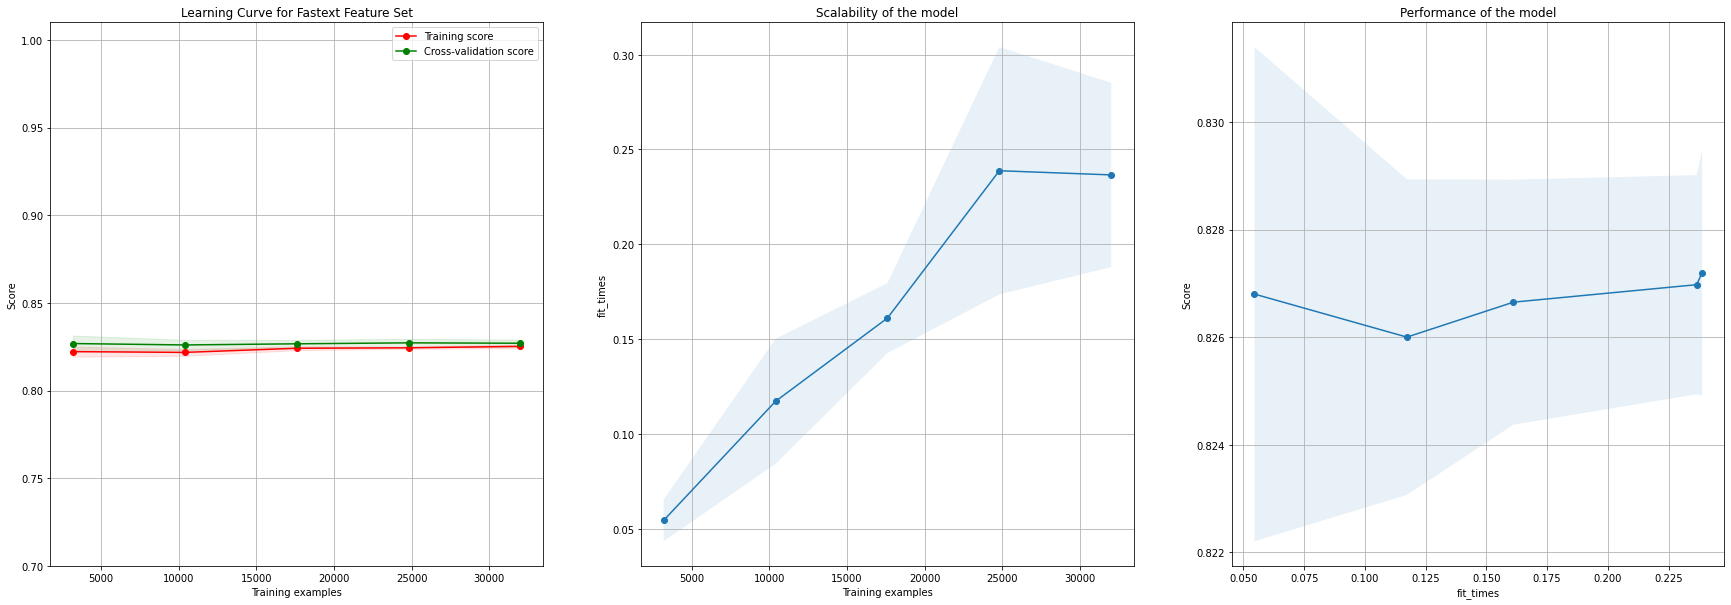

In [ ]:
title = "Learning Curve for Fastext Feature Set"
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
estimator = gnb
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(
    estimator, title, Fast_train_feature_, Y_train, axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
plt.show()

Auc Score 1
0.8891849783253845


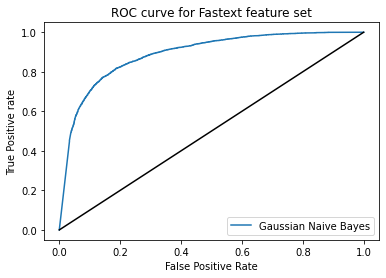

Area under curve = 0.8891849783253845


In [ ]:
plot_roc_inbuilt(gnb, Fast_test_feature_, Y_test, "Fastext feature set", "Gaussian Naive Bayes")

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train_features_final, Y_train)
gnb.score(X_test_features_final, Y_test)
# y_pred=gnb.predict(X_test_features_final)
# f1_score(Y_test,y_pred,average='macro')

0.7994

In [ ]:
print(get_scores(gnb, X_test_features_final, Y_test))

(0.7613041408852927, 0.7217960288808665, 0.8053877139979859)


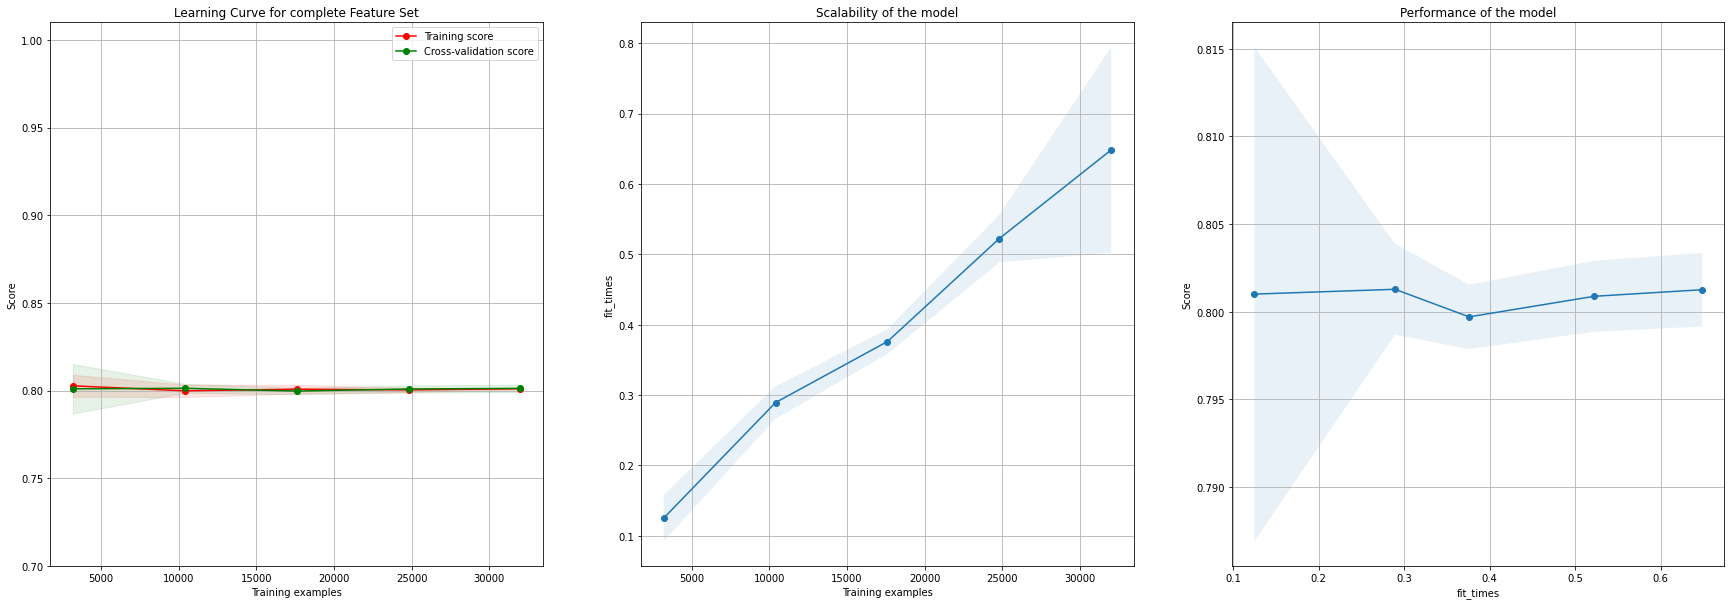

In [ ]:
title = "Learning Curve for complete Feature Set"
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
estimator = gnb
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(
    estimator, title, X_train_features_final, Y_train, axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
plt.show()

Auc Score 1
0.8491699694811257


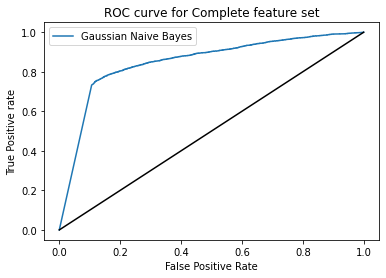

Area under curve = 0.8491699694811257


In [ ]:
plot_roc_inbuilt(gnb, X_test_features_final, Y_test, "Complete feature set", "Gaussian Naive Bayes")

# Decision Tree Classifier

In [ ]:
def DT_grid(X, Y, parameters):
  cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
  grid_search = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = parameters, n_jobs = -1, cv = 5, verbose = 1)
  grid_result = grid_search.fit(X, Y)
  return grid_result

parameters = {"criterion" : ['gini', 'entropy'], "max_depth" : range(1, 5), "min_samples_split" : range(1, 5), "min_samples_leaf" : range(1, 5)}


In [ ]:
pca = PCA(n_components = 25)
pca.fit(Char_train_feature.todense())
Char_train_feature_pca = pca.transform(Char_train_feature.todense())
Char_test_feature_pca = pca.transform(Char_test_feature.todense())
grid_result_char_DC = DT_grid(Char_train_feature_pca, Y_train, parameters)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [ ]:
print("Best: %f using %s" % (grid_result_char_DC.best_score_, grid_result_char_DC.best_params_))
print("Test results : %f" % (grid_result_char_DC.score(Char_test_feature_pca, Y_test)))

Best: 0.791000 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test results : 0.794400


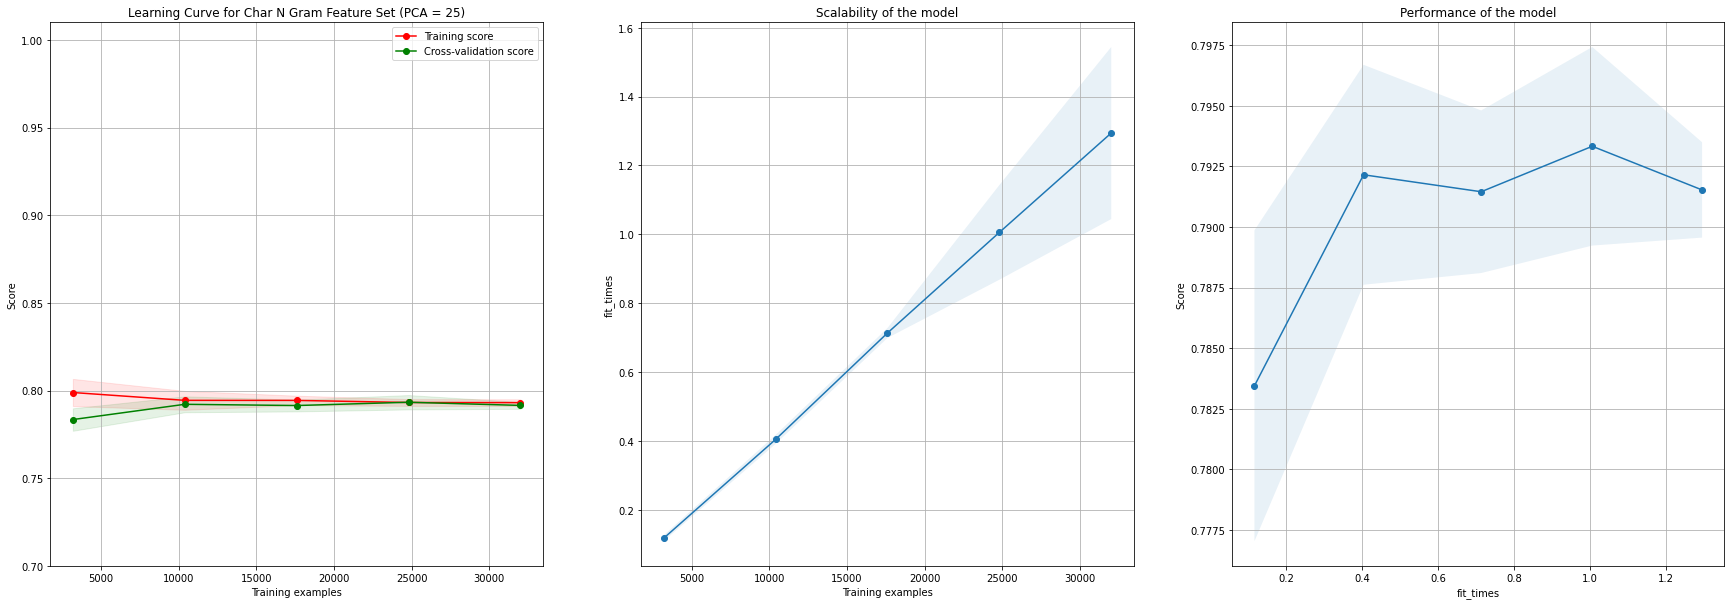

In [ ]:
title = "Learning Curve for Char N Gram Feature Set (PCA = 25)"
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
estimator = DecisionTreeClassifier(**grid_result_char_DC.best_params_)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(
    estimator, title, Char_train_feature_pca, Y_train, axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
plt.show()

Auc Score 1
0.8515349817668604


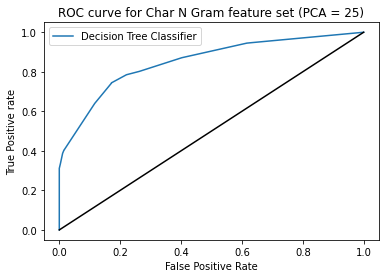

Area under curve = 0.8515349817668604


In [ ]:
plot_roc_inbuilt(grid_result_char_DC, Char_test_feature_pca, Y_test, "Char N Gram feature set (PCA = 25)", "Decision Tree Classifier")

In [ ]:
grid_result_word_DC = DT_grid(Word_train_feature, Y_train, parameters)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [ ]:
print("Best: %f using %s" % (grid_result_word_DC.best_score_, grid_result_word_DC.best_params_))
print("Test results : %f" % (grid_result_word_DC.score(Word_test_feature, Y_test)))

Best: 0.721350 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test results : 0.715000


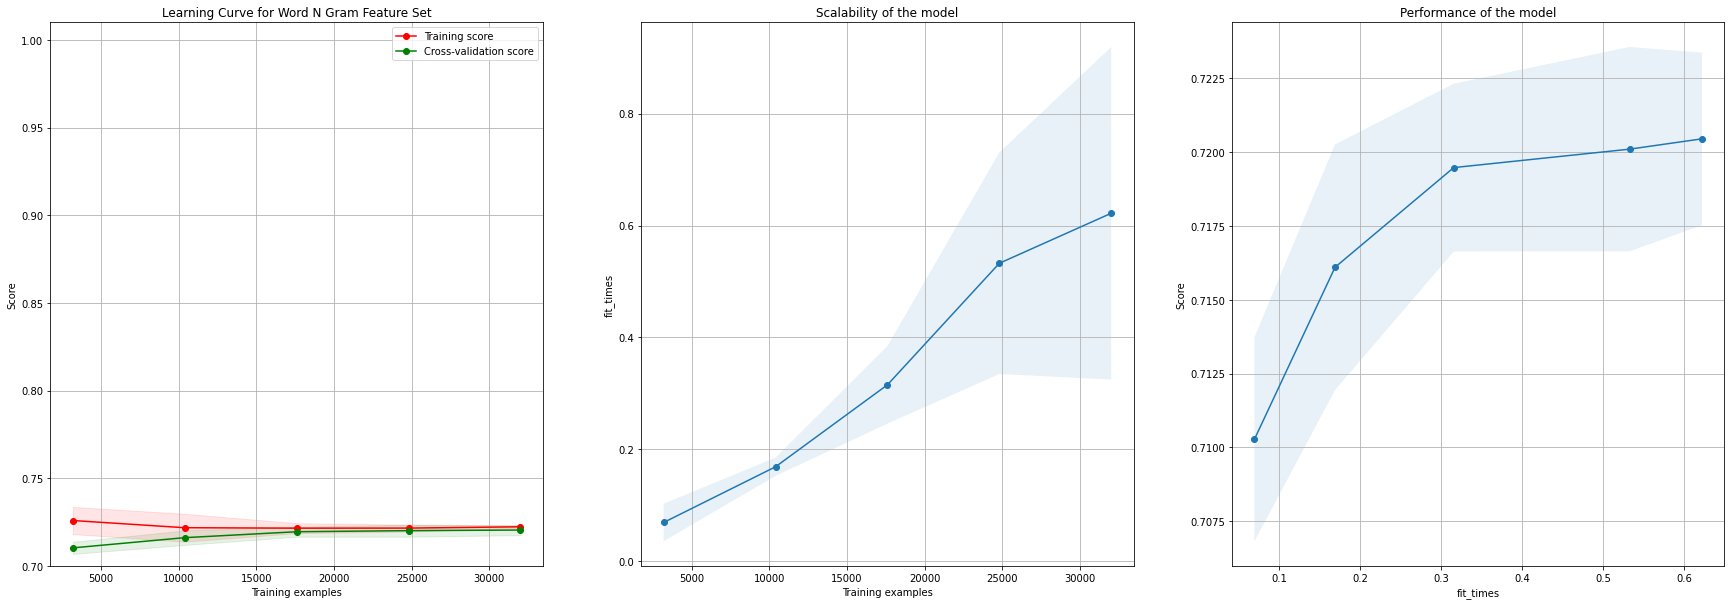

In [ ]:
title = "Learning Curve for Word N Gram Feature Set"
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
estimator = DecisionTreeClassifier(**grid_result_word_DC.best_params_)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(
    estimator, title, Word_train_feature, Y_train, axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
plt.show()

Auc Score 1
0.7538225023739501


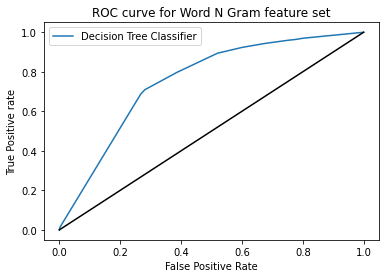

Area under curve = 0.7538225023739501


In [ ]:
plot_roc_inbuilt(grid_result_word_DC, Word_test_feature, Y_test, "Word N Gram feature set", "Decision Tree Classifier")

In [ ]:
grid_result_fast_DC = DT_grid(Fast_train_feature_, Y_train, parameters)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [ ]:
print("Best: %f using %s" % (grid_result_fast_DC.best_score_, grid_result_fast_DC.best_params_))
print("Test results : %f" % (grid_result_fast_DC.score(Fast_test_feature_, Y_test)))

Best: 0.855825 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test results : 0.851100


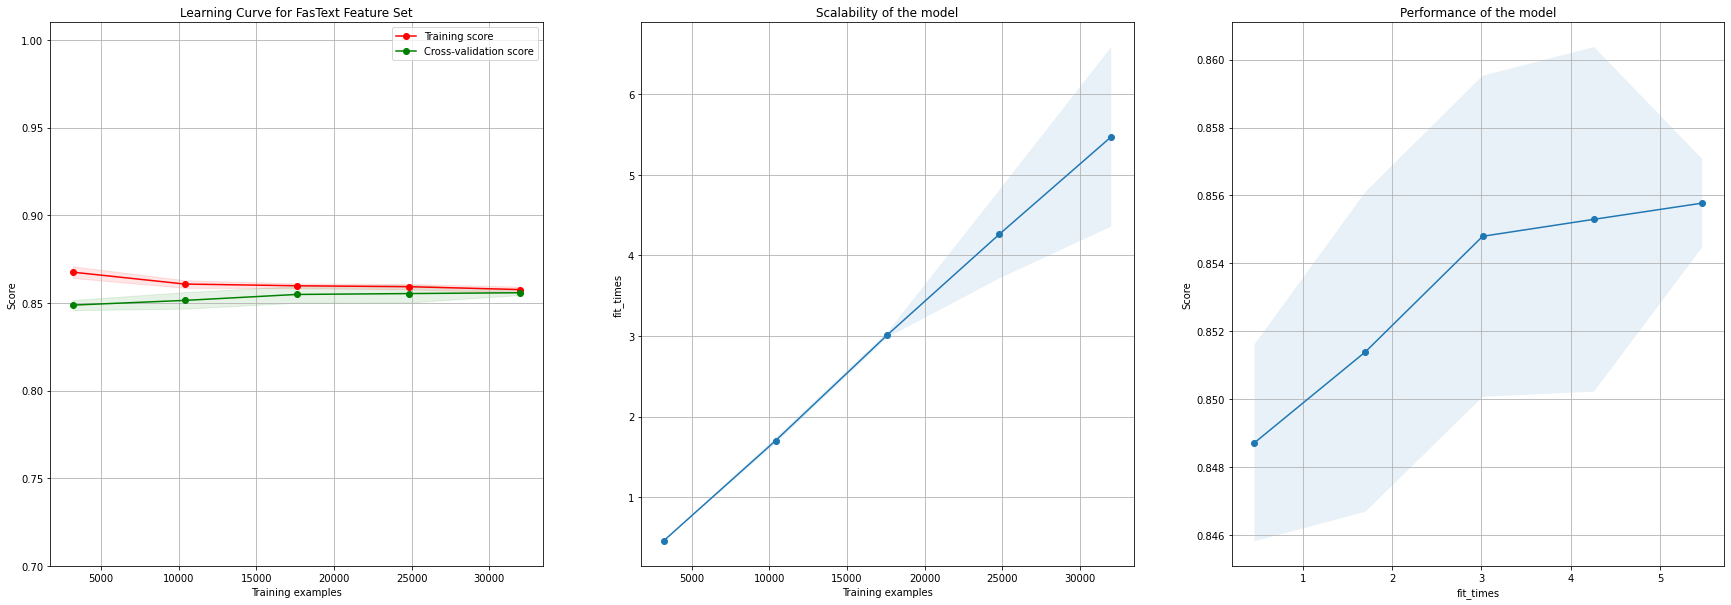

In [ ]:
title = "Learning Curve for FasText Feature Set"
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
estimator = DecisionTreeClassifier(**grid_result_fast_DC.best_params_)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(
    estimator, title, Fast_train_feature_, Y_train, axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
plt.show()

Auc Score 1
0.9040615304142936


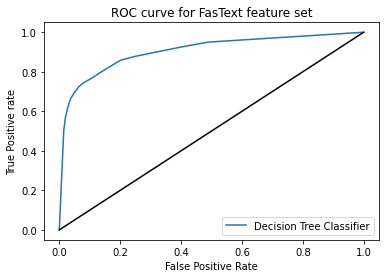

Area under curve = 0.9040615304142936


In [ ]:
plot_roc_inbuilt(grid_result_fast_DC, Fast_test_feature_, Y_test, "FasText feature set", "Decision Tree Classifier")

In [ ]:
pca = PCA(n_components = 75)
pca.fit(X_train_features_final)
print("Variance Retained in 75 principal features", sum(pca.explained_variance_ratio_ * 100))
pca_train_features_final = pca.transform(X_train_features_final)
pca_test_features_final = pca.transform(X_test_features_final)
grid_result_com_DT = DT_grid(pca_train_features_final, Y_train, parameters)

Variance Retained in 75 principal features 94.91017274416953
Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [ ]:
print(get_scores(grid_result_com_DT, pca_test_features_final, Y_test))

(0.7748229319791528, 0.825690686414127, 0.7298590130916415)


In [ ]:
print("Best: %f using %s" % (grid_result_com_DT.best_score_, grid_result_com_DT.best_params_))
print("Test results : %f" % (grid_result_com_DT.score(pca_test_features_final, Y_test)))

Best: 0.843075 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test results : 0.831500


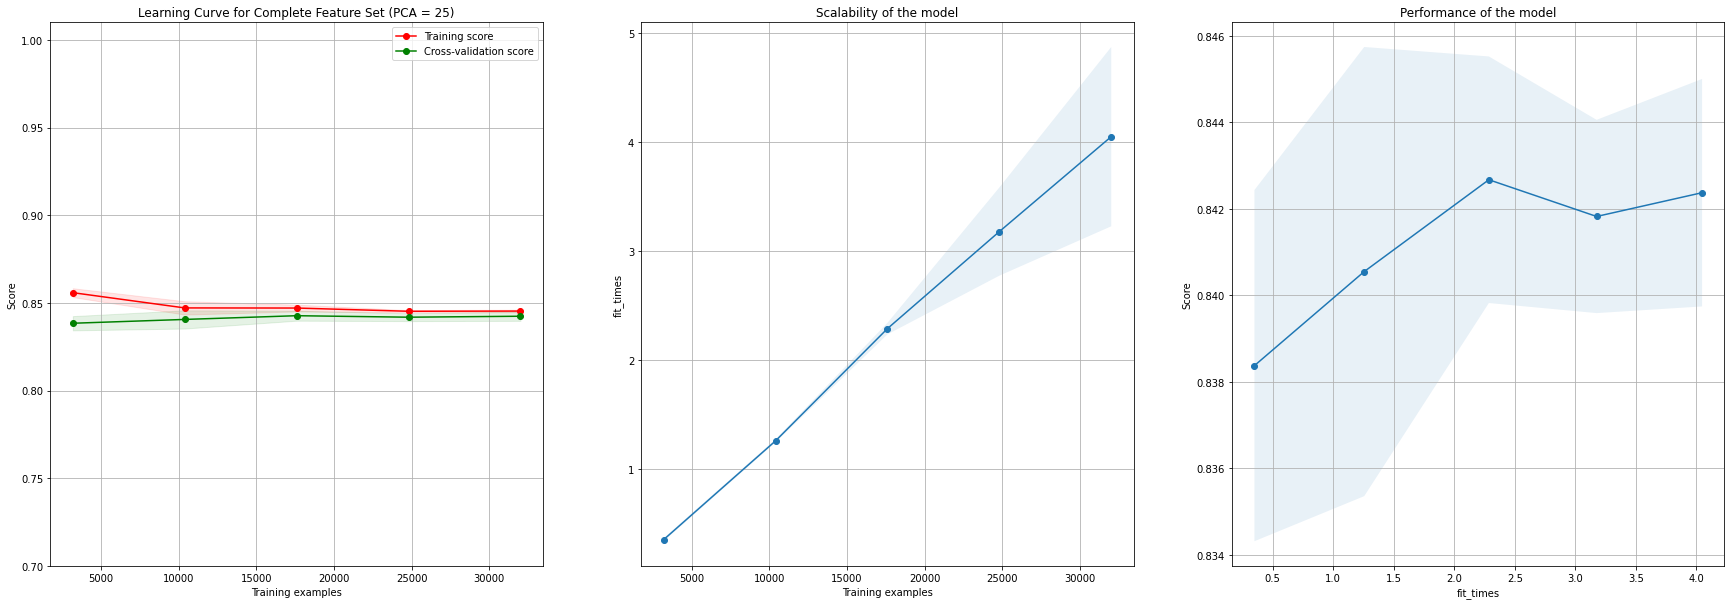

In [ ]:
title = "Learning Curve for Complete Feature Set (PCA = 25)"
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
estimator = DecisionTreeClassifier(**grid_result_com_DT.best_params_)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(
    estimator, title, pca_train_features_final, Y_train, axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
plt.show()

Auc Score 1
0.8831593466809138


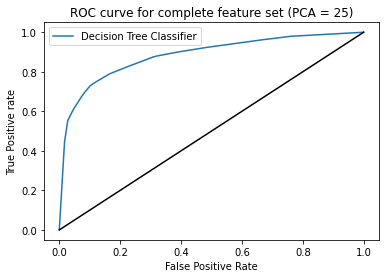

Area under curve = 0.8831593466809138


In [ ]:
plot_roc_inbuilt(grid_result_com_DT, pca_test_features_final, Y_test, "complete feature set (PCA = 25)", "Decision Tree Classifier")

# Random Forest

In [ ]:
def RF_grid(X, Y, parameters):
  cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
  grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = parameters, n_jobs = -1, cv = 5)
  grid_result = grid_search.fit(X, Y)
  return grid_result

parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 5, 8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
pca = PCA(n_components = 5)
pca.fit(Char_train_feature.todense())
print("Variance Retained in principal features", sum(pca.explained_variance_ratio_ * 100))
Char_train_feature_pca = pca.transform(Char_train_feature.todense())
Char_test_feature_pca = pca.transform(Char_test_feature.todense())
grid_result_char_RF = RF_grid(Char_train_feature_pca, Y_train, parameters)

Variance Retained in principal features 26.926512678035245


In [ ]:
print("Best: %f using %s" % (grid_result_char_RF.best_score_, grid_result_char_RF.best_params_))
print("Test results : %f" % (grid_result_char_RF.score(Char_test_feature_pca, Y_test)))

Best: 0.801925 using {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Test results : 0.804800
